In [1]:
%matplotlib inline
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import krotov
import scipy

F:\Anaconda\lib\site-packages\qutip\__init__.py:83: UserWarning: Old version of Cython detected: needed 0.29.20, got 0.29.13.
  .format(_cy_require, _Cython.__version__)


## Description of the STIRAP class

In the below cell is the definition for <code>class STIRAP()</code> and it's member functions. All functions which start with an underscore in their name are private and are not meant to be accessed from outside the class. Following is the description of the public member functions and their arguments.

* <code>self.efficiency_of_guess(x)</code>: here the input is a list object with two values. The value of <code>x[0]</code> is the end time of the stokes pulse as a fraction of total time and the value of <code>x[1]</code> is the start time of pump pulse as a fraction of total time. The output returned is the efficiency for this choice of pulse widths.

* <code>self.plot_for_guess(plot_pulses)</code>: here the input is a boolean which if given True will print the graph of the guess pulses of [blackman](https://en.wikipedia.org/wiki/Window_function#Blackman_window) shape. This is set to True by default. This function will show the final plot of the transfer of populations between the states.

* <code>self.krotov_opti_result(plot_pulses)</code>: here the input is again a boolean which when True will print the optimized graph pulses of intensity with phase and is set to True by default. The function will also show the final output of the population transfers between the states along with a printed log of the optimization details. The procedure used here is the [Krotov's method](https://qucontrol.github.io/krotov/v1.2.1/07_krotovs_method.html).

* <code>self.scipy_opti_result(plot_pulses)</code>: here the input is again a boolean which when True will print the optimized graph pulses (which remain blackman here) and is set to True by default. The function will also show the final output of the population transfers between the states along with a printed log of the optimization details. The procedure used here is the [Powell method](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-powell.html#optimize-minimize-powell) on three variables, the end time of the stokes pulse and start time of pump pulse and the two photon detuning ($\delta$).

In [74]:
class STIRAP():
    def __init__(self,Omega_S,Omega_P,E1,E2,E3,T,tS1,tS2,tP1,tP2,Δ=0,Gamma=0,delta=0,lam=1):
        self.Ω_S = Omega_S
        self.Ω_P = Omega_P
        self.E1 = E1
        self.E2 = E2
        self.E3 = E3
        self.T = T
        self.tS1 = tS1*T
        self.tS2 = tS2*T
        self.tP1 = tP1*T
        self.tP2 = tP2*T
        self.Δ = Δ - (1j*Gamma)
        self.efficiency = 0
        self.delta = delta
        self.lam = lam
    
    def _Omega_P1(self,t, args):
        return self.Ω_P*krotov.shapes.blackman(t, t_start=self.tP1, t_stop=self.tP2)

    def _Omega_P2(self,t, args):
        return 0.0

    def _Omega_S1(self,t, args):
        return self.Ω_S*krotov.shapes.blackman(t, t_start=self.tS1, t_stop=self.tS2)
    
    def _Omega_S2(self,t, args):
        return 0.0
    
    def _hamiltonian(self):
        # detunings
        ΔP = self.Δ #E1 + omega_P - E2
        ΔS = -ΔP + self.delta   #E3 + omega_S - E2
        H0 = Qobj([[0.0, 0.0, 0.0], [0.0,ΔP, 0.0], [0.0, 0.0,self.delta]])
        HP_re = 0.5 * Qobj([[0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [0.0, 0.0, 0.0]])
        HP_im = 0.5 * Qobj([[0.0, 1.0j, 0.0], [-1.0j, 0.0, 0.0], [0.0, 0.0, 0.0]])
        HS_re = 0.5 * Qobj([[0.0, 0.0, 0.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0]])
        HS_im = 0.5 * Qobj([[0.0, 0.0, 0.0], [0.0, 0.0, 1.0j], [0.0, -1.0j, 0.0]])
        return [H0,[HP_re, self._Omega_P1],[HP_im, self._Omega_P2],[HS_re, self._Omega_S1],[HS_im, self._Omega_S2],]
    
    def _final_result(self):
        kets = [qutip.Qobj(np.array([float(i is j) for j in range(3)])) for i in range(3)]
        psi_target = np.exp(1j * (self.E3 + self.Δ) * self.T) * kets[2]
        objective = krotov.Objective(initial_state=kets[0], target=psi_target, H=self._hamiltonian())
        tlist = np.linspace(0, self.T, 500)
        result = objective.mesolve(tlist, e_ops=[qutip.ket2dm(ket) for ket in kets])
        self.efficiency = result.expect[2][-1]
        return result,self.efficiency
    
    def efficiency_of_guess(self,x):
        self.tS2 = x[0]*self.T
        self.tP1 = x[1]*self.T
        self.delta = x[2]/self.T
        return self._final_result()[1]
    
    def _neg_eff(self,x):
        return -1*self.efficiency_of_guess(x)
        
    def plot_for_guess(self,plot_pulses=True):
        if plot_pulses:
            self._plot_pulse()
        result,_ = self._final_result()
        fig, ax = plt.subplots()
        ax.plot(result.times, result.expect[0], label='1')
        ax.plot(result.times, result.expect[1], label='2')
        ax.plot(result.times, result.expect[2], label='3')
        ax.legend()
        ax.set_xlabel('Time')
        ax.set_ylabel('Population')
        plt.show(fig)
    
    def _plot_pulse(self):
        tlist = np.linspace(0, self.T, 500)
        pulse = tlist
        if callable(self._Omega_P1) and callable(self._Omega_S1):
            pulse1 = np.array([self._Omega_P1(t, args=None) for t in tlist])
            pulse2 = np.array([self._Omega_S1(t, args=None) for t in tlist])
        plt.plot(tlist, pulse1,label="Pump")
        plt.plot(tlist, pulse2,label="Stokes")
        plt.xlabel('Time')
        plt.ylabel('Pulse amplitude')
        plt.legend()
        plt.show()
        
    def _shape(self,t):
        return krotov.shapes.flattop(t, t_start=0.0, t_stop=self.T, t_rise=self.T*0.2, func='sinsq')
    
    def _plot_pulse_amplitude_and_phase(self,pulse_real, pulse_imaginary,tlist):
        ax1 = plt.subplot(211)
        ax2 = plt.subplot(212)
        amplitudes = [np.sqrt(x*x + y*y) for x,y in zip(pulse_real,pulse_imaginary)]
        phases = [np.arctan2(y,x)/np.pi for x,y in zip(pulse_real,pulse_imaginary)]
        ax1.plot(tlist,amplitudes)
        ax1.set_xlabel('time')
        ax1.set_ylabel('pulse amplitude')
        ax2.plot(tlist,phases)
        ax2.set_xlabel('time')
        ax2.set_ylabel('pulse phase (π)')
        plt.show()
       
    def _krotov_optimization_routine(self):
        tlist = np.linspace(0, self.T, 500)
        H = self._hamiltonian()
        pulse_options = {
            H[1][1]: dict(lambda_a=self.lam, update_shape=self._shape),
            H[2][1]: dict(lambda_a=self.lam, update_shape=self._shape),
            H[3][1]: dict(lambda_a=self.lam, update_shape=self._shape),
            H[4][1]: dict(lambda_a=self.lam, update_shape=self._shape)}
        kets = [qutip.Qobj(np.array([float(i is j) for j in range(3)])) for i in range(3)]
        psi_target = np.exp(1j * (self.E3 + self.Δ) * self.T) * kets[2]
        objective = krotov.Objective(initial_state=kets[0], target=psi_target, H=self._hamiltonian())
        opt_result = krotov.optimize_pulses([objective],pulse_options,tlist,
            propagator=krotov.propagators.expm,
            chi_constructor=krotov.functionals.chis_re,
            info_hook=krotov.info_hooks.print_table(J_T=krotov.functionals.J_T_re,show_g_a_int_per_pulse=True,unicode=False,),
            check_convergence=krotov.convergence.Or(
            krotov.convergence.value_below(1e-3, name='J_T'),krotov.convergence.delta_below(1e-5),krotov.convergence.check_monotonic_error,),
            iter_stop=15,)
        return opt_result
    
    def _print_opti_pulse(self,opt_result):
        tlist = np.linspace(0, self.T, 500)
        print("pump pulse amplitude and phase:")
        self._plot_pulse_amplitude_and_phase(opt_result.optimized_controls[0], opt_result.optimized_controls[1], tlist)
        print("Stokes pulse amplitude and phase:")
        self._plot_pulse_amplitude_and_phase(opt_result.optimized_controls[2], opt_result.optimized_controls[3], tlist)
        
    def krotov_opti_result(self,print_pulse=True):
        kets = [qutip.Qobj(np.array([float(i is j) for j in range(3)])) for i in range(3)]
        tlist = np.linspace(0, self.T, 500)
        optimized = self._krotov_optimization_routine()
        if print_pulse:
            self._print_opti_pulse(optimized)
        result = optimized.optimized_objectives[0].mesolve(tlist, e_ops=[qutip.ket2dm(ket) for ket in kets])
        fig, ax = plt.subplots()
        ax.plot(result.times, result.expect[0], label='1')
        ax.plot(result.times, result.expect[1], label='2')
        ax.plot(result.times, result.expect[2], label='3')
        ax.legend()
        ax.set_xlabel('Time')
        ax.set_ylabel('Population')
        plt.show(fig)
        
    def scipy_opti_result(self,print_pulse=True):
        opti = scipy.optimize.minimize(self._neg_eff, x0=np.array([self.tS2,self.tP1,self.delta*self.T]), args=(), method='Powell', #bounds = [(0.1,1),(0,0.9),(-40,40)],
                                       options={'xtol': 0.0001, 'ftol': 0.0001, 'maxiter': 10, 'disp': True})
        print(opti)
        self.tS2 = opti.x[0]*self.T
        self.tP1 = opti.x[1]*self.T
        self.plot_for_guess()

### Example 1
Below is the simulation with both pulses having peak of 31.6 MHz and full overlap over a width of 20 $\mu s$. The single photon detuning is $\Delta = 1$ GHz and there is two photon resonance.

Efficiency = 0.997360312281279


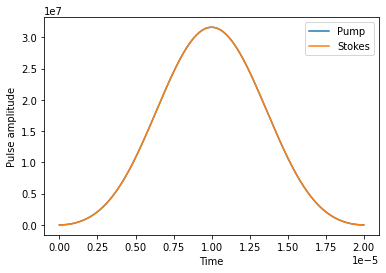

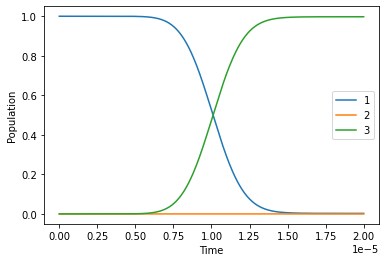

In [29]:
#Taking both as 31.6 MHz we can get effective rabi of approx 0.5 MHz with 1 GHz detuning
h = 6.626*(10**(-34))
hfs = 6.834673617*(10**9)
F_3 = 3.845*(10**14)
try_1 = STIRAP(Omega_S=31.6*10**6,Omega_P=31.6*10**6,E1=0,E2=hfs,E3=F_3,T=20*10**(-6),tS1=0,tS2=1,tP1=0,tP2=1,Δ=10**9,Gamma=6*10**6)
print("Efficiency = "+str(-try_1.efficiency_of_guess([1,0])))
try_1.plot_for_guess()

### Example 2
In this example we use with unequal peaks of 100 MHz peak for stokes and 10 MHz peak for pump. We use the scipy optimization to pick the optimal $\delta$, and the start time for pump and end for stokes. The ideal stokes end time comes to be larger than the total time but this is effective of it getting cut at the completion of $T$ since beyond that there would be no changes.

Optimization terminated successfully.
         Current function value: -0.999397
         Iterations: 3
         Function evaluations: 207
   direc: array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])
     fun: -0.9993967011959393
 message: 'Optimization terminated successfully.'
    nfev: 207
     nit: 3
  status: 0
 success: True
       x: array([1.42141472e+00, 4.20102192e-02, 1.12646845e+02])


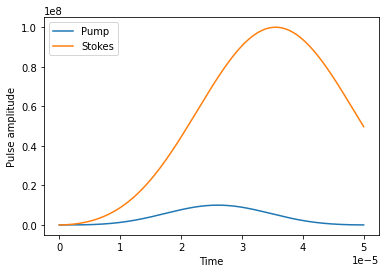

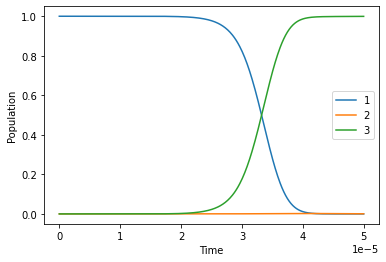

0.9993636005879369


In [75]:
trial = STIRAP(Omega_S=100*10**6,Omega_P=10*10**6,E1=0,E2=hfs,E3=F_3,T=5*10**(-5),tS1=0,tS2=0.8,tP1=0.14,tP2=1,Δ=10**9,Gamma=0*6*10**6,delta=2.088*10**6)
trial.scipy_opti_result()
print(str(trial.efficiency_of_guess([trial.tS2/trial.T,trial.tP1/trial.T,trial.delta*trial.T])))

### Example 3
In the following example we use the same peaks as the previous one but this time use a different guess and try and see whether we can optimize with krotov. The krotov optimization however performs very poorly and with a little analysis this seems to be an occurence for large detuning case in specefic as it is able to optimize when the detuning is of the same scale as the rabi peaks and time scale is appropriate.

Efficiency = 0.27421826076539735


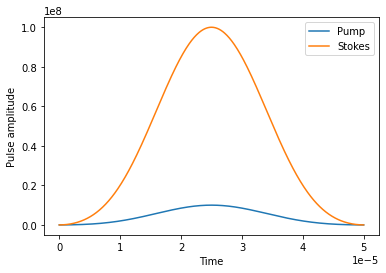

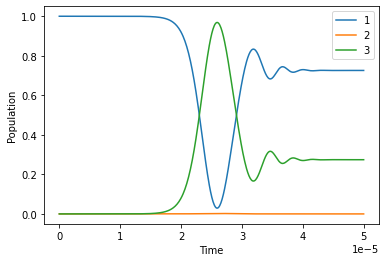

In [55]:
try_2 = STIRAP(Omega_S=100*10**6,Omega_P=10*10**6,E1=0,E2=hfs,E3=F_3,T=5*10**(-5),tS1=0,tS2=1,tP1=0,tP2=1,Δ=10**9,Gamma=0*6*10**6,delta=2.088*10**6)
print("Efficiency = "+str(try_2.efficiency_of_guess([1,0])))
try_2.plot_for_guess()

iter.      J_T   g_a_int_1   g_a_int_2   g_a_int_3   g_a_int_4    g_a_int          J  Delta J_T    Delta J  secs
0     1.21e+00    0.00e+00    0.00e+00    0.00e+00    0.00e+00   0.00e+00   1.21e+00        n/a        n/a    16
1     1.21e+00    9.38e-10    7.56e-10    9.15e-10    2.12e-11   2.63e-09   1.21e+00  -5.12e-09  -2.49e-09    49
pump pulse amplitude and phase:


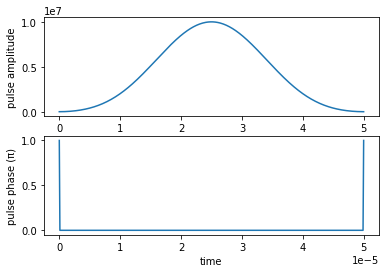

Stokes pulse amplitude and phase:


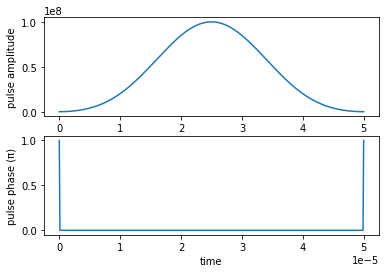

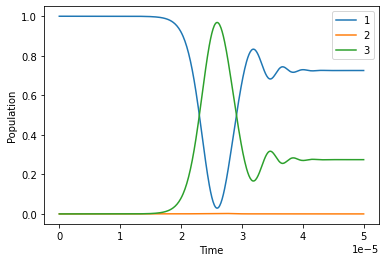

In [56]:
try_2.krotov_opti_result()